In [1]:
import pandas as pd

lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')[['raceId', 'driverId', 'lap']]
races = races = pd.read_csv('races.csv')[["raceId", "circuitId"]]

In [2]:
#Data Preprocessing

lap_times = lap_times.merge(races, on='raceId', how='left')
lap_times['normalized_time'] = lap_times['milliseconds'] / lap_times.groupby('raceId')['milliseconds'].transform('min')
lap_times = lap_times.merge(pit_stops[['raceId', 'driverId', 'lap']], on=['raceId', 'driverId', 'lap'], how='left', indicator=True)
lap_times['is_pit_stop'] = lap_times['_merge'] == 'both'
lap_times.drop(columns=['_merge'], inplace=True)
lap_times['is_pit_exit'] = lap_times['is_pit_stop'].shift(1, fill_value=False)
# Example: Filter out laps with normalized_time > 1.5 (assuming it's an anomaly)
lap_times = lap_times[lap_times['normalized_time'] <= 1.5]

In [3]:
lap_times

,raceId,driverId,lap,position,time,milliseconds,circuitId,normalized_time,is_pit_stop,is_pit_exit
0,841,20,1,1,1:38.109,98109,1,1.103005,False,False
1,841,20,2,1,1:33.006,93006,1,1.045634,False,False
2,841,20,3,1,1:32.713,92713,1,1.042340,False,False
3,841,20,4,1,1:32.803,92803,1,1.043352,False,False
4,841,20,5,1,1:32.342,92342,1,1.038169,False,False
...,...,...,...,...,...,...,...,...,...,...
589076,1144,857,54,10,1:27.731,87731,24,1.024452,False,False
589077,1144,857,55,10,1:27.781,87781,24,1.025036,False,False
589078,1144,857,56,10,1:27.816,87816,24,1.025445,False,False
589079,1144,857,57,10,1:28.554,88554,24,1.034062,False,False


In [4]:
#Feature Engineering

features = ['circuitId', 'lap', 'is_pit_stop', 'is_pit_exit']

lap_times['lag_1'] = lap_times.groupby(['raceId', 'driverId'])['normalized_time'].shift(1)
lap_times['lag_2'] = lap_times.groupby(['raceId', 'driverId'])['normalized_time'].shift(2)
features += ['lag_1', 'lag_2']
lap_times.head()

,raceId,driverId,lap,position,time,milliseconds,circuitId,normalized_time,is_pit_stop,is_pit_exit,lag_1,lag_2
0,841,20,1,1,1:38.109,98109,1,1.103005,False,False,NaN,NaN
1,841,20,2,1,1:33.006,93006,1,1.045634,False,False,1.103005,NaN
2,841,20,3,1,1:32.713,92713,1,1.042340,False,False,1.045634,1.103005
3,841,20,4,1,1:32.803,92803,1,1.043352,False,False,1.042340,1.045634
4,841,20,5,1,1:32.342,92342,1,1.038169,False,False,1.043352,1.042340


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Drop NaNs and prepare data
lap_times.dropna(subset=features + ['normalized_time'], inplace=True)
X = lap_times[features]
y = lap_times['normalized_time']

# Split data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 0.002933422713571484


In [7]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test)

# Calculate the MSE for the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('Random Forest MSE:', mse_rf)

# For comparison, print the MSE of the linear regression model if you haven't already
y_pred_lr = model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print('Linear Regression MSE:', mse_lr)

# Optionally, you could calculate the improvement in MSE
improvement = mse_lr - mse_rf
print('MSE Improvement:', improvement)

Random Forest MSE: 0.0017135437680398026
Linear Regression MSE: 0.002933422713571484
MSE Improvement: 0.0012198789455316811


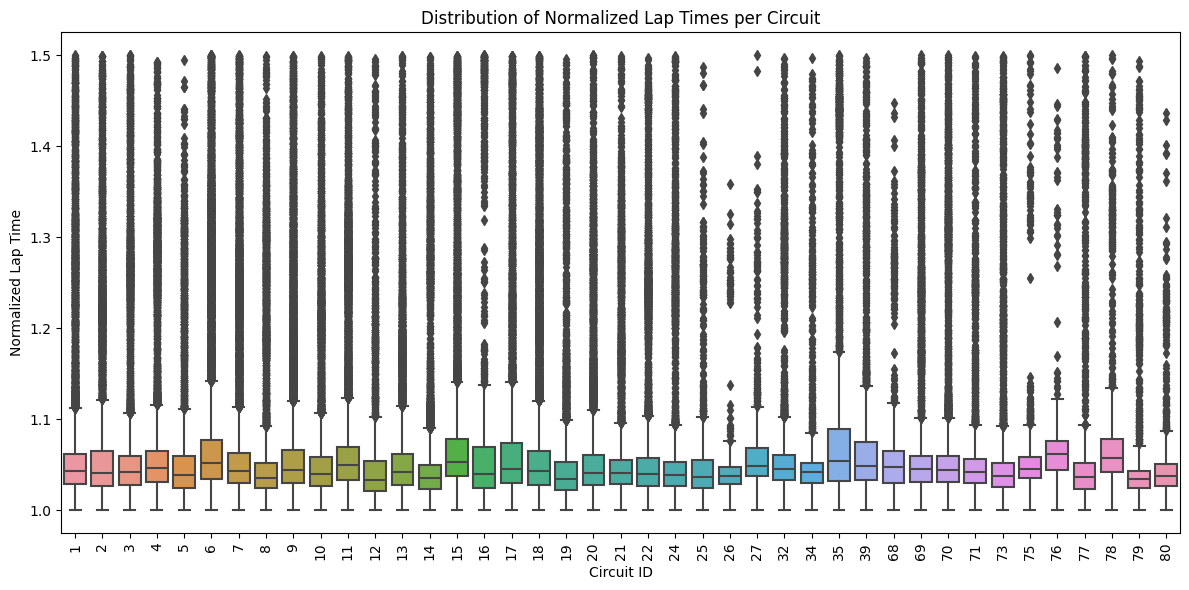

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=lap_times, x='circuitId', y='normalized_time')
plt.title('Distribution of Normalized Lap Times per Circuit')
plt.xlabel('Circuit ID')
plt.ylabel('Normalized Lap Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/Users/parz/miniforge3/envs/data-science/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/parz/miniforge3/envs/data-science/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


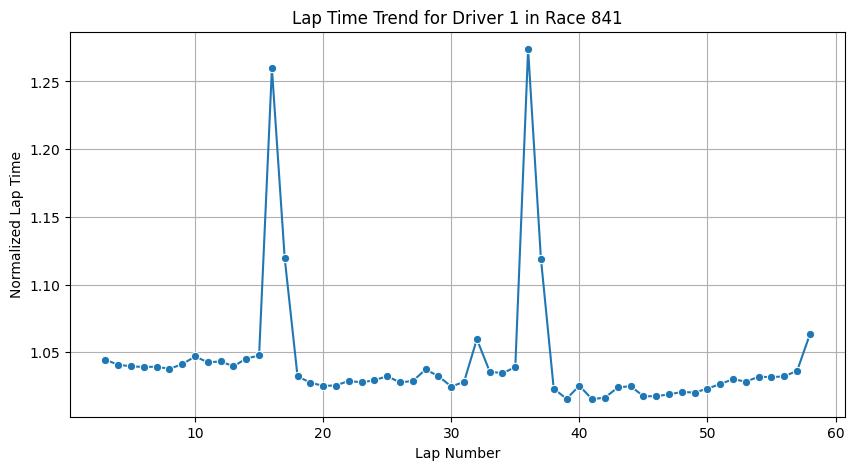

In [11]:
race_sample = lap_times[lap_times['raceId'] == 841]  # Example race
driver_sample = race_sample[race_sample['driverId'] == 1]

plt.figure(figsize=(10, 5))
sns.lineplot(data=driver_sample, x='lap', y='normalized_time', marker='o')
plt.title('Lap Time Trend for Driver 1 in Race 841')
plt.xlabel('Lap Number')
plt.ylabel('Normalized Lap Time')
plt.grid(True)
plt.show()

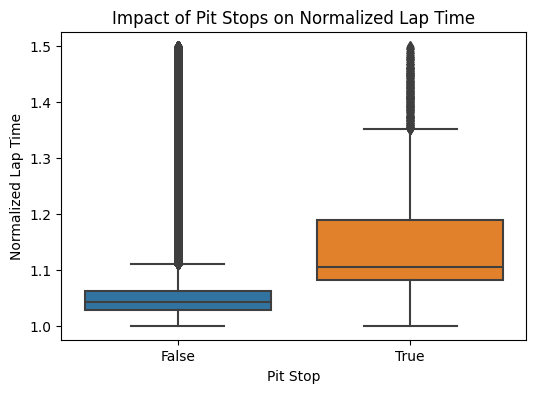

In [12]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=lap_times, x='is_pit_stop', y='normalized_time')
plt.title('Impact of Pit Stops on Normalized Lap Time')
plt.xlabel('Pit Stop')
plt.ylabel('Normalized Lap Time')
plt.show()

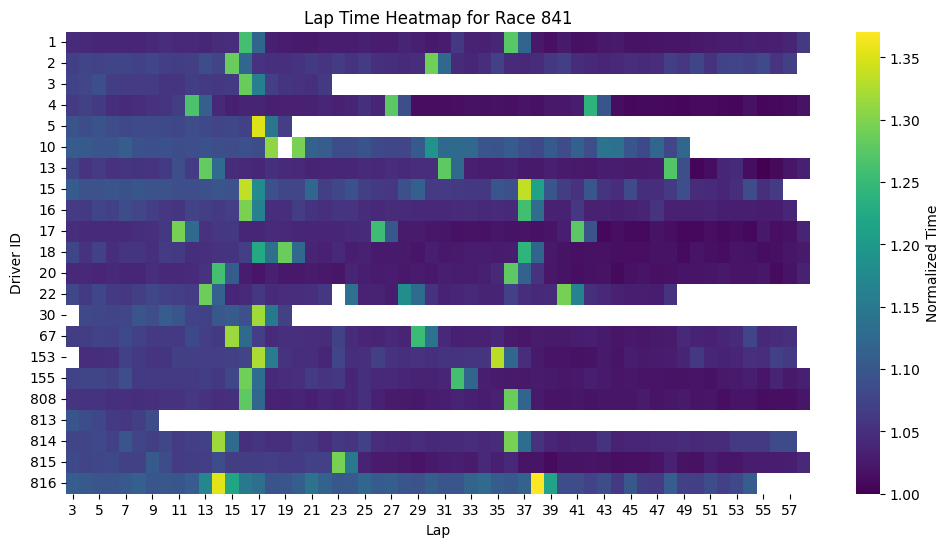

In [14]:
race_laps = lap_times[lap_times['raceId'] == 841].pivot(index='driverId', columns='lap', values='normalized_time')

plt.figure(figsize=(12, 6))
sns.heatmap(race_laps, cmap='viridis', cbar_kws={'label': 'Normalized Time'})
plt.title('Lap Time Heatmap for Race 841')
plt.xlabel('Lap')
plt.ylabel('Driver ID')
plt.show()